<a href="https://colab.research.google.com/github/Abdelmounim1996/TDA/blob/main/TDA_s%C3%A9ance_II_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master 2 Université Sorbonne Paris Nord -ED Galilée-

## TDA séances en machine

# TD2: TDA et featurisation pour le Machine Learning

# Résumé de la séance I:

 1. Cercle avec bruit Gaussien (en faisant varier la variance du bruit)

 2. Deux cercles concentrent toujours avec bruit Gaussien

 3. Nuage de points tirés de façon uniforme dans le cube unité (pour voir ce qu'un truc contractible va donner) en   
    augmentant petit à petit le nombre de points tirés. Ca nous permet de voir ce que donne un truc sans structure 
    topologique remarquable

 4. On reprend les deux premiers exemples en mettant un outlier (un point très loin des cercles) et on refait les  
    diagrammes. Cela permet de signaler la sensibilité des méthodes de TDA aux outliers. On peut alors parler de la
    DTM (distance to a measure) pour gérer ce genre de problème


# Exemple type

In [2]:
pip install -U giotto-tda

     |████████████████████████████████| 1.5 MB 17.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 404 kB 40.1 MB/s 
     |████████████████████████████████| 3.1 MB 52.7 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
np.random.seed(seed=42)
from gtda.homology import VietorisRipsPersistence
from sklearn.datasets import make_circles

In [4]:
#sigma = bruit 
def circleUnif(n=30, radius=1, sigma=0, center=(0, 0)):
    radii = np.random.randn(n) * sigma + radius
    angles = np.random.rand(n) * np.pi * 2

    x = radii * np.cos(angles)
    y = radii * np.sin(angles)

    return np.transpose([x, y]) + center

In [5]:
Circle1 = circleUnif(60, 1, 0.05, (0,0))
Circle2 = circleUnif(60, 2, 0.03, (3,3))

Circles = np.concatenate([Circle1, Circle2], axis=0)

In [6]:
#On utilise la méthode gtda
from gtda.plotting import plot_point_cloud
plot_point_cloud(Circles)

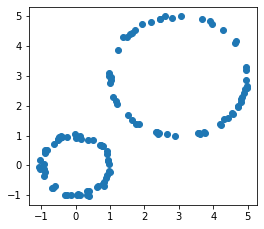

In [7]:
# Ou bien on utilise matplotlib au lieu de gtda plot module pour les designer
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 8))
ax = plt.subplot(221)
ax.scatter(Circles[:,0], Circles[:,1])
plt.show()

In [8]:
# On calcule le diagramme de persistance et le designe en utilisant gtda:

# Initialize the Vietoris–Rips transformer
VR = VietorisRipsPersistence(homology_dimensions=[0,1,2])

# Compute persistence diagrams of all point clouds
diags = VR.fit_transform(Circles[None,:,:])

# Et finalement on le designe pour le 3-ème groupe de homologie
VR.plot(diags)


In [9]:
# Si on veux que les composants conexes et loops
VR.plot(diags, homology_dimensions=[0,1])

# TDA et Machine Learning: la TDA sert à fabriquer des covariables


## Méthodes de vectorisation des diagrammes: Landscape et Silohuette

In [10]:
from gtda.diagrams import PersistenceLandscape, Silhouette

In [11]:
pl = PersistenceLandscape()
plc = pl.fit_transform_plot(diags)

In [12]:
sl = Silhouette()
slc = sl.fit_transform_plot(diags)

### Although persistence diagrams are useful descriptors of the data, they cannot be used directly for machine learning applications. For instance, they have got different numbers of points. To overcome these limitations, we “vectorize” persistence diagrams via embeddings or kernels which are well-suited for machine learning.

### For example, one such feature is known as persistence entropy which measures the entropy of points in a diagram $D$.

Information provides a way to quantify the amount of surprise for an event measured in bits.

Entropy provides a measure of the average amount of information needed to represent an event drawn from a probability distribution for a random variable.

In [13]:
import os
import sys

sys.path.append("./generate_dataset.py")

In [14]:
def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)
                           
    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                 for t in range(n_points)
                 for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)
                           
    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)
                           
    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))
                           
    return point_clouds, labels

In [20]:
!git clone https://github.com/giotto-ai/giotto-tda

Cloning into 'giotto-tda'...
remote: Enumerating objects: 13659, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 13659 (delta 79), reused 84 (delta 29), pack-reused 13494
Receiving objects: 100% (13659/13659), 59.05 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (8180/8180), done.


In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
import sys
sys.path.append('/content/giotto-tda/examples/data') 

In [35]:
import generate_datasets

In [38]:
point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=10, n_points=20, noise=0.5)
point_clouds_basic.shape, labels_basic.shape

((30, 400, 3), (30,))

In [39]:
labels_basic

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [40]:
plot_point_cloud(point_clouds_basic[0])

In [41]:
plot_point_cloud(point_clouds_basic[-4])

In [42]:
plot_point_cloud(point_clouds_basic[12])

In [43]:
diagrams = VR.fit_transform(point_clouds_basic)

In [44]:
diagrams.shape

(30, 595, 3)

In [45]:
#Cercle
from gtda.plotting import plot_diagram
plot_diagram(diagrams[0]) #ou VR.plot() aussi ==> (diagrams, sample=0)

In [46]:
# Sphere
VR.plot(diagrams, sample=12)

In [47]:
# Torus
VR.plot(diagrams, sample=-4)

1. Le cercle a un generateur persistante $H_{1}$ qui correspond aux trous,

2. Le sphere a un generateur persistante $H_{2}$ qui correspond aux trous 2-dimensionnel,

3. Le torus a trois generateurs persistantes, deux pour $H{1}$ et un pour $H_{2}$.

In [48]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams)

# expect shape - (n_point_clouds, n_homology_dims)
X_basic.shape

(30, 3)

In [49]:
X_basic

array([[8.46165251, 4.76791711, 1.67841649],
       [8.45003193, 4.24478575, 1.59573545],
       [8.45800971, 4.80008438, 1.9745997 ],
       [8.46188156, 4.51310795, 2.01718923],
       [8.47689493, 4.76792973, 1.51713872],
       [8.46263595, 4.45161614, 0.89039069],
       [8.44734822, 4.34137978, 0.98844596],
       [8.48284978, 4.52142261, 1.37239145],
       [8.46753072, 4.36146742, 1.25106211],
       [8.44731029, 4.24765136, 1.45153028],
       [8.53952365, 6.58977436, 1.73670566],
       [8.51478784, 6.60758021, 1.31457786],
       [8.53545087, 6.58892855, 1.88783292],
       [8.53559605, 6.74666064, 2.04562362],
       [8.52729053, 6.75752741, 2.34900627],
       [8.53343429, 6.61245925, 1.04961508],
       [8.5344288 , 6.66883678, 1.98045437],
       [8.524888  , 6.81670149, 1.18487005],
       [8.51792757, 6.61075535, 1.45342841],
       [8.53806529, 6.67379643, 1.8138403 ],
       [8.53974736, 6.42624961, 3.56650331],
       [8.55218109, 6.37565206, 3.59907303],
       [8.

In [50]:
help(PersistenceEntropy)

Help on class PersistenceEntropy in module gtda.diagrams.features:

class PersistenceEntropy(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  PersistenceEntropy(normalize=False, nan_fill_value=-1.0, n_jobs=None)
 |  
 |  :ref:`Persistence entropies <persistence_entropy>` of persistence
 |  diagrams.
 |  
 |  Given a persistence diagram consisting of birth-death-dimension triples
 |  [b, d, q], subdiagrams corresponding to distinct homology dimensions are
 |  considered separately, and their respective persistence entropies are
 |  calculated as the (base 2) Shannon entropies of the collections of
 |  differences d - b ("lifetimes"), normalized by the sum of all such
 |  differences. Optionally, these entropies can be normalized according to a
 |  simple heuristic, see `normalize`.
 |  
 |  **Important notes**:
 |  
 |      - Input collections of persistence diagrams for this transformer must
 |        satisfy certain requirements, see e.g. :meth:`fit`.
 |      - By defaul

In [51]:
plot_point_cloud(X_basic)

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_basic, labels_basic)

print(f"OOB score: {rf.oob_score_:.3f}")

OOB score: 1.000


In [54]:
help(rf.fit)

Help on method fit in module sklearn.ensemble._forest:

fit(X, y, sample_weight=None) method of sklearn.ensemble._forest.RandomForestClassifier instance
    Build a forest of trees from the training set (X, y).
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The training input samples. Internally, its dtype will be converted
        to ``dtype=np.float32``. If a sparse matrix is provided, it will be
        converted into a sparse ``csc_matrix``.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
        The target values (class labels in classification, real numbers in
        regression).
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If None, then samples are equally weighted. Splits
        that would create child nodes with net zero or negative weight are
        ignored while searching for a split in each node. In the case of
        classification

### Exercice 1. 

Téléchargez les données "shapes" en suivant les commandes suivants:
 
 from openml.datasets.functions import get_dataset

 df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]
 
 df.head()

Ensuite répetez la vectorisation avec eux! (Landscape, silhouette) 



In [ ]:
pip install openml

In [64]:
import openml

In [67]:
from openml.datasets.functions import get_dataset
from sklearn.datasets import fetch_openml
XX, target = fetch_openml('shapes', return_X_y=True)#.get_data(dataset_format='dataframe')[0]

In [68]:
yy = XX.target

In [69]:
yy

0        human_arms_out9
1        human_arms_out9
2        human_arms_out9
3        human_arms_out9
4        human_arms_out9
              ...       
15995           biplane8
15996           biplane8
15997           biplane8
15998           biplane8
15999           biplane8
Name: target, Length: 16000, dtype: category
Categories (40, object): ['human_arms_out9', 'human_arms_out8', 'human_arms_out5', 'human_arms_out4',
                          ..., 'biplane6', 'biplane7', 'biplane9', 'biplane8']

In [70]:
help(fetch_openml)


Help on function fetch_openml in module sklearn.datasets._openml:

fetch_openml(name: Union[str, NoneType] = None, *, version: Union[str, int] = 'active', data_id: Union[int, NoneType] = None, data_home: Union[str, NoneType] = None, target_column: Union[str, List, NoneType] = 'default-target', cache: bool = True, return_X_y: bool = False, as_frame: Union[str, bool] = 'auto')
    Fetch dataset from openml by name or dataset id.
    
    Datasets are uniquely identified by either an integer ID or by a
    combination of name and version (i.e. there might be multiple
    versions of the 'iris' dataset). Please give either name or data_id
    (not both). In case a name is given, a version can also be
    provided.
    
    Read more in the :ref:`User Guide <openml>`.
    
    .. versionadded:: 0.20
    
    .. note:: EXPERIMENTAL
    
        The API is experimental (particularly the return value structure),
        and might have small backward-incompatible changes without notice
        

### Exercice 2. 

Répetez la tâche de classification de formes évaluées au dessus en utilisant un autre classifieur, par exemple,
knn, Naïve Bayes, etc.

## TDA et série temporel

function is periodic with period $T>0$ if $f(t+T)=f(t)$ for all $t\in\mathbb R$. For example, consider the function $f(t)= sin(7t)$, which can be visualised as follows:

In [71]:
import plotly.graph_objects as go

In [72]:
#An exemple periodique
x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.sin(7 * x_periodic)

fig = go.Figure(data=go.Scatter(x=x_periodic, y=y_periodic))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

In [73]:
#An exemple periodique
x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.sign(np.sin(x_periodic))
fig = go.Figure(data=go.Scatter(x=x_periodic, y=y_periodic))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

We can show that periodicity implies ellipticity of the time delay embedding. To do that we need to specify the 
embedding dimension $d$ and the time delay $\tau$ for the Takens embedding, which can be achieved as follows:

rappel: In the study of dynamical systems, a delay embedding theorem gives the conditions under which a 
       chaotic dynamical system can be reconstructed from a sequence of observations of the state of 
       a dynamical system.
       
Le théorème de Taken (1981) ou plongement de retard de Taken nous donne les conditions nécessaires pour 
lesquelles on peut reconstruire un attracteur à partir des obversations faites avec une fontion générique. Alors, ça veut dire que:

Si on a une séquence de séries temporelles  $x_{1},x_{2},\dots,x_{n}$  tirés depuis un attracteur de dimension superieur via the multivariate time-series
⎛⎝⎜⎜⎜⎜xixi+τ⋮xi+(d−1)⋅τ⎞⎠⎟⎟⎟⎟i,
 
where  $\tau$  is the delay and  $d$  is the embedding dimension.

Application de la tda à la classification de séries temporelles

In [74]:
from gtda.time_series import SingleTakensEmbedding

In [75]:
embedding_dimension_periodic = 5
embedding_time_delay_periodic = 8
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride, # downsample the time delay embedding pour vite calculer le diagramme de persistance 
)

In [76]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

Shape of embedded time series: (97, 5)


In [77]:
y_periodic_embedded

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1., -1.],
       [ 1.,  

In [78]:
plot_point_cloud(y_periodic_embedded)

En effet, the periodicity of $f$ is reflected in the ellipticity of the time delay embedding! It turns out that in general, 
periodic functions trace out ellipses in $\mathbb R^{d}$.

In [79]:
# non-périodique
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.sin(x_nonperiodic) + np.sin(np.pi * x_nonperiodic)

fig = go.Figure(data=go.Scatter(x=x_nonperiodic, y=y_nonperiodic))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

In [80]:
#Même operation
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16
stride = 3

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y_nonperiodic)

plot_point_cloud(y_nonperiodic_embedded)

# Apparemment ces deux nuages de points ont une topologie différente, mais il va falloir le calculer avec le diagramme de persistance

In [81]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

In [82]:
# 0 - connected components, 1 - loops, 2 - voids
#homology_dimensions = [0, 1, 2]

#periodic_persistence = VR(
#    homology_dimensions=homology_dimensions, n_jobs=4
#)
print("Persistence diagram for periodic signal")
VR.fit_transform_plot(y_periodic_embedded)

#nonperiodic_persistence = VR(
#    homology_dimensions=homology_dimensions, n_jobs=4
#)
print("Persistence diagram for nonperiodic signal")
VR.fit_transform_plot(y_nonperiodic_embedded);

Persistence diagram for periodic signal


Persistence diagram for nonperiodic signal


These clear differences in topology make the time delay embedding technique especially powerful at 
classifying different time series.

In [83]:
#from gtda.plotting import plot_betti_curves
from gtda.diagrams import BettiCurve
bn = BettiCurve()
bc = bn.fit_transform_plot(diags)
bc.shape

(1, 3, 100)

In [84]:
bn.fit_transform_plot(VR.fit_transform(y_periodic_embedded))
bn.fit_transform_plot(VR.fit_transform(y_nonperiodic_embedded))

array([[[322, 322, 322, 322, 322, 319, 316, 312, 298, 292, 292, 292,
         292, 292, 292, 292, 292, 292, 292, 292, 291, 291, 291, 291,
         290, 290, 290, 290, 290, 290, 289, 289, 289, 289, 287, 287,
         287, 286, 286, 285, 283, 282, 282, 282, 282, 282, 282, 282,
         280, 280, 280, 278, 278, 278, 278, 276, 274, 273, 271, 271,
         269, 268, 268, 266, 265, 264, 259, 259, 255, 248, 243, 234,
         226, 216, 210, 199, 188, 180, 174, 166, 159, 155, 145, 142,
         136, 133, 124, 115, 111, 106,  99,  93,  82,  76,  70,  58,
          47,  32,  13,   0],
        [  1,   1,   4,   6,   6,   6,   6,   5,   4,   3,   3,   3,
           3,   3,   3,   2,   3,   4,   4,   5,   6,   8,  10,   8,
          19,  26,  29,  30,  33,  36,  41,  44,  42,  42,  44,  44,
          47,  48,  48,  50,  50,  50,  49,  49,  46,  43,  44,  41,
          39,  38,  37,  38,  37,  38,  38,  31,  35,  34,  34,  34,
          35,  32,  32,  30,  32,  30,  29,  29,  30,  30,  30,  27,
    

### Exercice 1.

Répeter avec un autre fonction périodique, par exemple $cos(kt)$

### Exercice 2.
Utiliser un autre filtration et vérifier que les numéros de betti sont invariants.

### Exercice 3.
Selectioner les données "shapes" au dessus pour calculer les Betti Curves et les designer plus tard.

### Exercice 4. Optional
Choisir la dimension du plongement ainsi que du retard temporel de façon automatique en utilisant la information mutuelle et le "false nearest neighbours"

In [85]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [86]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (70000, 784), y shape: (70000,)


In [87]:
X = X.to_numpy()

In [88]:
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "8")[0]
img8 = X[im8_idx].reshape(28,28)
plot_heatmap(img8)

In [89]:
from sklearn.model_selection import train_test_split

train_size, test_size = 80, 10

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X = X.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (80, 28, 28), y_train shape: (80,)
X_test shape: (10, 28, 28), y_test shape: (10,)


In [90]:
from gtda.plotting import plot_heatmap

im2_idx = np.flatnonzero(y == "2")[0]
img2 = X[im2_idx].reshape(28,28)
plot_heatmap(img2)

In [91]:
from gtda.images import Binarizer

# Pick out index of first 8 image
#im8_idx = np.flatnonzero(y_train == "8")[0]
# Reshape to (n_samples, n_pixels_x, n_pixels_y) format
im2 = X[im2_idx][None, :, :]

binarizer = Binarizer(threshold=0.4)
im2_binarized = binarizer.fit_transform(im2)

binarizer.plot(im2_binarized)

In [92]:
from gtda.images import Binarizer

# Pick out index of first 8 image
#im8_idx = np.flatnonzero(y_train == "8")[0]
# Reshape to (n_samples, n_pixels_x, n_pixels_y) format
im8 = X_train[im8_idx][None, :, :]

binarizer = Binarizer(threshold=0.4)
im8_binarized = binarizer.fit_transform(im8)

binarizer.plot(im8_binarized)

In [93]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([20, 6]))
im8_filtration = radial_filtration.fit_transform(im8_binarized)

radial_filtration.plot(im8_filtration, colorscale="jet")

In [94]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([20, 6]))
im2_filtration = radial_filtration.fit_transform(im2_binarized)

radial_filtration.plot(im2_filtration, colorscale="jet")

In [95]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
im2_cubical = cubical_persistence.fit_transform(im2_filtration)

cubical_persistence.plot(im2_cubical)

In [96]:
help(CubicalPersistence)

Help on class CubicalPersistence in module gtda.homology.cubical:

class CubicalPersistence(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, gtda.base.PlotterMixin)
 |  CubicalPersistence(homology_dimensions=(0, 1), coeff=2, periodic_dimensions=None, infinity_values=None, reduced_homology=True, n_jobs=None)
 |  
 |  :ref:`Persistence diagrams <persistence_diagram>` resulting from
 |  :ref:`filtered cubical complexes <cubical_complex>`.
 |  
 |  Given a :ref:`greyscale image <cubical_chains_and_cubical_homology>`,
 |  information about the appearance and disappearance of topological features
 |  (technically, :ref:`homology classes <homology_and_cohomology>`) of various
 |  dimensions and at different scales is summarised in the corresponding
 |  persistence diagram.
 |  
 |  **Important note**:
 |      - Persistence diagrams produced by this class must be interpreted with
 |        care due to the presence of padding triples which carry no
 |        information. See :meth:`tr

In [97]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
im8_cubical = cubical_persistence.fit_transform(im8_filtration)

cubical_persistence.plot(im8_cubical)

In [98]:
from gtda.diagrams import Scaler

scaler = Scaler()
im8_scaled = scaler.fit_transform(im8_cubical)

scaler.plot(im8_scaled)

In [99]:
im8_basic = persistence_entropy.fit_transform(im8_cubical)

In [100]:
plot_point_cloud(im8_basic)

In [101]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy, Amplitude
from gtda.images import HeightFiltration

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [102]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

(80, 476)

In [103]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

X_test_tda = tda_union.transform(X_test)
rf.score(X_test_tda, y_test)

1.0

In [104]:
X_test_tda.shape


(10, 476)

In [105]:
X_test_tda

array([[ 0.00000000e+00,  0.00000000e+00,  1.11111111e-01, ...,
         3.12738837e-02,  1.93288560e-04,  2.53103998e-03],
       [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.89862193e-02,  9.60005222e-05,  2.27932460e-03],
       [ 0.00000000e+00, -1.00000000e+00,  2.77777778e-01, ...,
         0.00000000e+00,  1.92560411e-04,  0.00000000e+00],
       ...,
       [ 8.11278124e-01, -1.00000000e+00,  1.66666667e-01, ...,
         0.00000000e+00,  1.41836243e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.88888889e-01, ...,
         2.70796443e-02,  2.43920596e-04,  2.09642609e-03],
       [-1.00000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.55637481e-05,  0.00000000e+00]])

In [106]:
y_test

65183    8
59567    6
20453    5
52546    9
43567    1
57420    0
36021    3
56096    7
2518     2
38518    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [107]:
import gtda.diagrams

In [108]:
help(gtda.diagrams)

Help on package gtda.diagrams in gtda:

NAME
    gtda.diagrams

DESCRIPTION
    The module :mod:`gtda.diagrams` implements transformers to preprocess
    persistence diagrams, extract features from them, or compute pairwise distances
    between diagrams.

PACKAGE CONTENTS
    _features
    _metrics
    _utils
    distance
    features
    preprocessing
    representations
    tests (package)

CLASSES
    gtda.base.PlotterMixin(builtins.object)
        gtda.diagrams.preprocessing.Filtering(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, gtda.base.PlotterMixin)
        gtda.diagrams.preprocessing.ForgetDimension(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, gtda.base.PlotterMixin)
        gtda.diagrams.preprocessing.Scaler(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, gtda.base.PlotterMixin)
        gtda.diagrams.representations.BettiCurve(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, gtda.base.PlotterMixin)
        gtda.diagrams.represe

In [109]:
df =XX
plot_point_cloud(df.query('target == "biplane0"')[["x", "y", "z"]].values)

In [110]:
plot_point_cloud(df.query('target == "vase0"')[["x", "y", "z"]].values)

In [111]:
plot_point_cloud(df.query('target == "human_arms_out0"')[["x", "y", "z"]].values)

In [112]:
help(df.query)

Help on method query in module pandas.core.frame:

query(expr: 'str', inplace: 'bool' = False, **kwargs) method of pandas.core.frame.DataFrame instance
    Query the columns of a DataFrame with a boolean expression.
    
    Parameters
    ----------
    expr : str
        The query string to evaluate.
    
        You can refer to variables
        in the environment by prefixing them with an '@' character like
        ``@a + b``.
    
        You can refer to column names that are not valid Python variable names
        by surrounding them in backticks. Thus, column names containing spaces
        or punctuations (besides underscores) or starting with digits must be
        surrounded by backticks. (For example, a column named "Area (cm^2)" would
        be referenced as ```Area (cm^2)```). Column names which are Python keywords
        (like "list", "for", "import", etc) cannot be used.
    
        For example, if one of your columns is called ``a a`` and you want
        to sum it

In [113]:
#Next, let’s collect all these point clouds in a single NumPy array:
point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)
point_clouds.shape

(40, 400, 3)

In [114]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=[0,1,2],
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(point_clouds)

In [115]:
# Index - (human_arms_out, 0), (vase, 10), (dining_chair, 20), (biplane, 30)
index = 30
plot_diagram(persistence_diagrams[index])

In [116]:
#Next we convert each diagram into a 3-dimensional vector using persistent entropy and plot the resulting feature matrix:

persistence_entropy = PersistenceEntropy(normalize=True)

# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)

# Visualise feature matrix
plot_point_cloud(X)

# Unlike our simple shapes example, we do not see distinct clusters so we expect our classifier performance to be less than perfect in this case. Before we can train a model, we need to define a target vector for each point cloud. A crude, but simple way is to label each class with an integer starting from 0 to number of classes-1:

In [117]:
labels = np.zeros(40)
labels[10:20] = 1
labels[20:30] = 2
labels[30:] = 3

rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(X, labels)
rf.oob_score_

0.6

In [118]:
#augment this information with other topological features to produce better models.

#For example, a simple feature to include is the number of off-diagonal points per homology dimension:

from gtda.diagrams import NumberOfPoints

# Reshape single diagram to (n_samples, n_features, 3) format
diagram = persistence_diagrams[0][None, :, :]
# Get number of points for (H0, H1, H2)
NumberOfPoints().fit_transform(diagram)

array([[399,  87,  10]])

In [119]:
#A more sophisticated feature is to calculate a vector of amplitudes for each persistence diagram.
from gtda.diagrams import Amplitude

Amplitude(metric='wasserstein').fit_transform(diagram)

array([[0.22923933, 0.06502641, 0.02047913]])

In [120]:
#So now that we know how to generate new topological features, let’s combine them using scikit-learn’s utility function for feature unions:

from sklearn.pipeline import make_union

# Select a variety of metrics to calculate amplitudes
metrics = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape", "persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)

In [121]:
#The final step is to combine our feature extraction step with a classifier, fit the pipeline, and extract the OOB score:

from gtda.pipeline import Pipeline

pipe = Pipeline(
    [
        ("features", feature_union),
        ("rf", RandomForestClassifier(oob_score=True, random_state=42)),
    ]
)
pipe.fit(persistence_diagrams, labels)
pipe["rf"].oob_score_

0.825

# Image de persistence
Given a persistence diagram consisting of birth-death-dimension triples [b, d, q], the equivalent diagrams of birth-persistence-dimension [b, d-b, q] triples are computed and subdiagrams corresponding to 
distinct homology dimensions are considered separately and regarded as sums of Dirac deltas. Then, the convolution 
with a Gaussian kernel is computed over a rectangular grid of locations evenly sampled from appropriate ranges of the 
filtration parameter. The result can be thought of as a (multi-channel) raster image.

In [123]:
from gtda.diagrams import PersistenceImage

PI = PersistenceImage()
ri = PI.fit_transform_plot(persistence_diagrams, sample=7)
ri.shape

(1, 3, 100, 100)

In [124]:
help(PersistenceImage.fit_transform_plot)

Help on function fit_transform_plot in module gtda.base:

fit_transform_plot(self, X, y=None, sample=0, **plot_params)
    Fit to data, then apply :meth:`transform_plot`.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, ...)
        Input data.
    
    y : ndarray of shape (n_samples,) or None
        Target values for supervised problems.
    
    sample : int
        Sample to be plotted.
    
    **plot_params
        Optional plotting parameters.
    
    Returns
    -------
    Xt : ndarray of shape (1, ...)
        Transformed one-sample slice from the input.

